<a href="https://colab.research.google.com/github/RupamDas-ts/Image-Copy-Move-Forgery-Detection/blob/Trial-Code/Copy_move_Image_Forgery_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing libreries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

import pandas as pd
from PIL import Image
import glob
import tensorflow as tf
import pickle
#from scipy.misc import toimage


In [ ]:
#Reading image and convert into gray scale image
def readImage(imgPath):
    img = cv2.imread(imgPath)
    grayScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayScale

In [ ]:
#Spliting the image into overlapping blocks of size 'block'
def imageSplit(img, block):
    splitted = []
    coordinate = []
    for r in range(0,img.shape[0]-block+1,1): #start,stop,step
        for c in range(0,img.shape[1]-block+1,1):
            cropped = img[r:r+block, c:c+block]
            splitted.append(cropped)

            coordinate.append(np.array([r,c]))
    return splitted,coordinate

In [ ]:
#storing the GLCM features in an array GLCMfeatures
# def DiscreteCosineTransform(blocks,w):

#     GaborFeatures = []
    
#     counter = 0
#     i=0
#     j=0
#     for patch in blocks:
#         i = int(counter/w)
#         j = counter%w

#         fltMatrix = np.float32(patch)/255.0
#         dct = cv2.dct(fltMatrix)
#         imgcv1 = np.uint8(dct*255.0).flatten()
        
#         temp = []

#         for x in imgcv1:
#           temp.append(x)

#         #adding the coordinates of the patch
#         temp.append(i)
#         temp.append(j)

#         GaborFeatures.append(np.array(temp))
        
#         counter += 1
    
#     return GaborFeatures

In [ ]:
import numpy as np
from scipy.fftpack import dct

def circle_block_dct_coeffs(patch, radius):
    """
    Form a circle block DCT coefficient matrix from an image patch.

    Parameters:
    - patch: a 2D numpy array representing the image patch.
    - radius: an integer representing the radius of the circle block.

    Returns:
    - a 2D numpy array representing the circle block DCT coefficient matrix.
    """
    # Calculate the dimensions of the patch and the center of the patch
    rows, cols = patch.shape
    center = (rows/2, cols/2)

    # Create a meshgrid of the same dimensions as the patch
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))

    # Calculate the distance of each point from the center
    r = np.sqrt((x-center[1])**2 + (y-center[0])**2)

    # Create a boolean mask where True indicates that the point is inside the circle block
    mask = (r <= radius)

    # Zero-pad the patch to make it square
    side_length = max(rows, cols)
    padded_patch = np.zeros((side_length, side_length))
    padded_patch[:rows, :cols] = patch

    # Apply the DCT to the padded patch
    dct_patch = dct(dct(padded_patch, axis=0), axis=1)

    # Apply the mask to the DCT coefficients to form the circle block DCT coefficient matrix
    circle_block_dct_coeffs = dct_patch[mask]

    return circle_block_dct_coeffs



In [ ]:
def DiscreteCosineTransform(blocks,coordinate):

    GaborFeatures = []
    counter = 0;
    for patch in blocks:
        i = coordinate[counter][0]
        j = coordinate[counter][1]

        fltMatrix = np.float32(patch)/255.0
        dct = cv2.dct(fltMatrix)
        imgcv1 = np.uint8(dct*255.0).flatten()
        
        
        temp = []

        for x in imgcv1:
          temp.append(x)

        #adding the coordinates of the patch
        temp.append(i)
        temp.append(j)

        GaborFeatures.append(np.array(temp))
        
        counter += 1
    
    return GaborFeatures

In [ ]:
#lexiographical sorting function
def lexiographicalSort(Features):
    sorted_index = np.lexsort(np.rot90(Features))
    sorted_Features = []
    for i in range (0,len(sorted_index),1):
        sorted_Features.append(Features[sorted_index[i]])
    return sorted_Features

#sorted_index = np.lexsort(np.rot90(ImageFeatures))
#sorted_Features = []
#for i in range (0,len(sorted_index),1):
#   sorted_Features.append(ImageFeatures[sorted_index[i]])
#sorted_Features

In [ ]:
def absoluteDiff(f1,f2,threshold):
  diff = []
  for i in range(0,4,1):
    diff.append(f1[i]-f2[i])
  #print(diff)
  for j in diff:
    if(abs(j) >= threshold):
      return False
  return True

In [ ]:
def EuclideanDistance(feature1,feature2):
  length = len(feature1)
  x = []
  y = []
  #print(length)
  for i in range(length-2,length,1): #last 2 values of the feature vectors are coordinates of the bloack having that specific feature
    x.append(feature1[i])
    y.append(feature2[i])
  
  x = np.array(x)
  y = np.array(y)
  
  return np.sqrt(np.sum(np.square(x-y)))

In [ ]:
def SimilarBlocks(features):
  
  similarity_threshold = 0.0000001
  similarBlockCoordinateList = []
  l = len(features[0])

  for i in range(0,len(features)-1,1):
    feature1 = features[i]
    feature2 = features[i+1]
    #check if abs diff of tw features is less than the similarity_threshold
    if(absoluteDiff(feature1[0:4],feature2[0:4],similarity_threshold)):
      
      #if difference less than the similarity_threshold, calculate Euclidean Distance of the matching blocks
      euclideanDist = EuclideanDistance(feature1,feature2)

      #Check if Euclidean Distance of the matching blocks is greater than a pre-defined value, 16
      if(euclideanDist>16):
        #add coordinates of the matching blocks to the list [x1,y1,x2,y2]
        c = np.concatenate((np.array(feature1[l-2:]),np.array(feature2[l-2:])), axis=None)
        similarBlockCoordinateList.append(c)

  return similarBlockCoordinateList

In [ ]:
def SimilarImagePatches(similarBlocks,h,w,patchSize):
  
  my_img_1 = np.zeros((h, w), dtype = "uint8")

  #print(my_img_1)
  

  for i in similarBlocks:
    x1 = i[0]
    y1 = i[1]
    x2 = i[2]
    y2 = i[3]

    # if (x1+patchSize)>=512 or (y1+patchSize)>=512 or (x2+patchSize)>=512 or (y2+patchSize)>=512:
    #   print(i)
      
    #   return

    for j in range(x1,x1+patchSize-1,1):
      for k in range(y1,y1+patchSize-1,1):
        my_img_1[j,k] = 255.00

    for l in range(x2,x2+patchSize-1,1):
      for m in range(y2,y2+patchSize-1,1):
        my_img_1[l,m] = 255.00
  
  #cv2_imshow(np.uint8(my_img_1))
  return np.uint8(my_img_1)

In [ ]:
def AccuracyCheck(img,correctDataSet):
  
  #correctDataSet = readImage('/content/drive/MyDrive/Project_files/001_B.png')

  correct = 0
  total = 0

  for i in range(0,img.shape[0],1):
    for j in range(0,img.shape[1],1):
      if img[i][j] in range(correctDataSet[i][j]-50, correctDataSet[i][j]+50):
        correct = correct+1
      total = total+1
  
  return float(correct/total)

In [ ]:
def createImageGrid(Image1,Image2,Image3,Image4):

  # create figure
  fig = plt.figure(figsize=(10, 10))

  # setting values to rows and column variables
  rows = 2
  columns = 2

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(Image1[:,:,::-1])
  plt.axis('off')
  plt.title("Original Image")

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)

  # showing image
  plt.imshow(Image2,cmap='gray')
  plt.axis('off')
  plt.title("GreyScale Image")

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)

  # showing image
  plt.imshow(Image3,cmap='gray')
  plt.axis('off')
  plt.title("Output")

  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, 4)

  # showing image
  plt.imshow(Image4,cmap='gray')
  plt.axis('off')
  plt.title("Correct Output")


64
[64653.00648510459, 100.79265879676299, 37.85015364431017, -129.7619122210642]
Accuracy(%) =  44.98558044433594


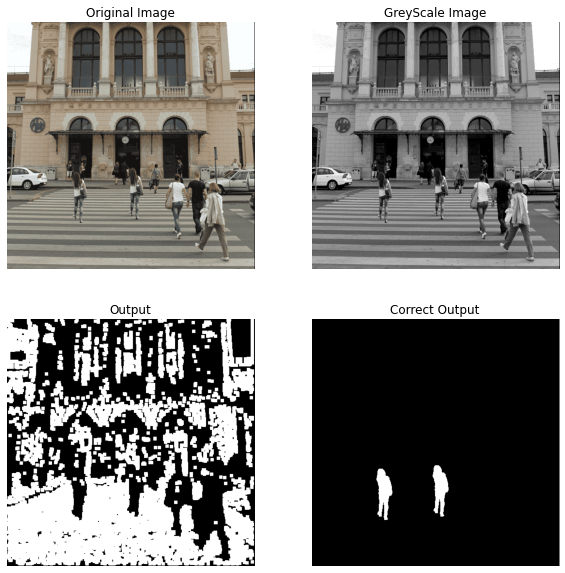

In [ ]:
#Main body
patchSize = 8
grayScale = readImage('/content/drive/MyDrive/Project_files/001_F.png')
h, w = grayScale.shape

patches, coordinate = imageSplit(grayScale, patchSize)
#print(*coordinate, sep = "\n")

#######################################################
#Trying Circle-Block DCT
circle_block = circle_block_dct_coeffs(patches[0],8)
print(circle_block.size)
f1 = 0
for i in range(0,16,1):
  f1 = f1 + circle_block[i]

f2 = 0
for i in range(16,32,1):
  f2 = f2 + circle_block[i]

f3 = 0
for i in range(32,48,1):
  f3 = f3 + circle_block[i]

f4 = 0
for i in range(48,64,1):
  f4 = f4 + circle_block[i]

features = []
features.append(f1)
features.append(f2)
features.append(f3)
features.append(f4)
print(features)
#####################################

#featureVectors = DiscreteCosineTransform(patches,w-patchSize) #w is image width
featureVectors = DiscreteCosineTransform(patches,coordinate)


sortedFeatureVectors = lexiographicalSort(featureVectors)
#print(*sortedFeatureVectors, sep = "\n")


similarBlocks = SimilarBlocks(sortedFeatureVectors)
#print(*similarBlocks, sep = "\n")

ForgeryMarkedImage = SimilarImagePatches(similarBlocks,h,w,patchSize)

correctDataSet = readImage('/content/drive/MyDrive/Project_files/001_B.png')
accuracy = AccuracyCheck(ForgeryMarkedImage,correctDataSet)

createImageGrid(cv2.imread('/content/drive/MyDrive/Project_files/001_F.png'),grayScale,ForgeryMarkedImage,correctDataSet)

print("Accuracy(%) = ",accuracy*100)


# New Section